# CatGAN

This is a generative adversarial network to produce cat images. It was trained on the cat dataset with 64x64 images from Kaggle. Here, we generate the images using two architecutres - the DCGAN and the vanilla GAN proposed by Goodfellow. Credits to https://github.com/soumith/ganhacks this article for providing insights into training effectively.

## Setup

In [24]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import CatDataset as cdset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(64, 64, 3))
    return 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

We will use the Kaggle dataset of cats (64x64) which can be downloaded from the `data.sh` script.

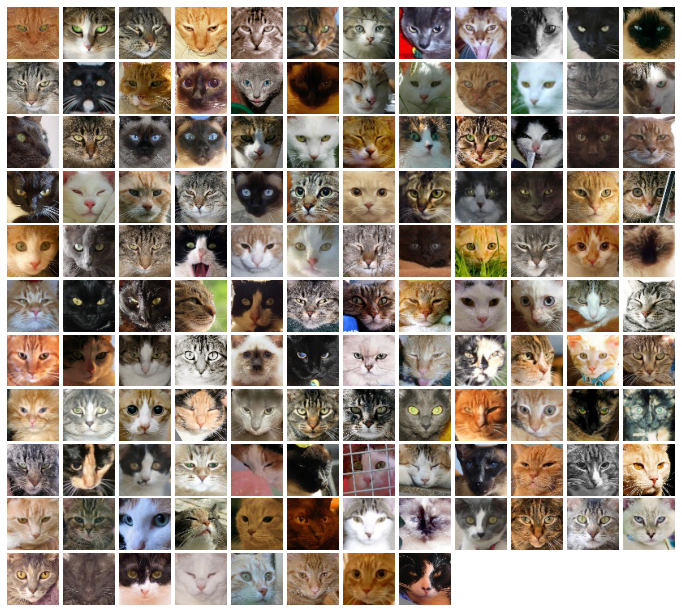

In [37]:
NUM_TRAIN = 10000
NUM_VAL = 3000

NOISE_DIM = 96
batch_size = 128

cat_train = cdset.CatDataset('./cats')
loader_train = DataLoader(cat_train, batch_size=batch_size,
                          shuffle=True)

cat_val = cdset.CatDataset('./cats')
loader_val = DataLoader(cat_val, batch_size=batch_size,
                        shuffle=True)

imgs = loader_train.__iter__().next().view(batch_size, 4096, 3).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Implement `sample_noise` in `cs231n/gan_pytorch.py`.

Hint: use `torch.rand`.

Make sure noise is the correct shape and type:

In [32]:
from helpers.gan import sample_noise

def test_sample_noise(): 
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim, 3)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


In [33]:
from helpers.gan import Flatten, Unflatten, initialize_weights

## CPU / GPU

In [6]:
# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

Implement `discriminator` in `cs231n/gan_pytorch.py`

Test to make sure the number of parameters in the discriminator is correct:

In [35]:
from helpers.gan import discriminator

# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])
 
 Implement `generator` in `cs231n/gan_pytorch.py`

Test to make sure the number of parameters in the generator is correct:

In [40]:
from helpers.gan import generator

ImportError: cannot import name 'generator' from 'helpers.gan' (C:\Users\jaide\Desktop\GIT-Projects\Cat-GAN\helpers\gan.py)

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

Implement `bce_loss`, `discriminator_loss`, `generator_loss` in `cs231n/gan_pytorch.py`

Test your generator and discriminator loss. You should see errors < 1e-7.

In [27]:
from cs231n.gan_pytorch import bce_loss, discriminator_loss, generator_loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 3.97058e-09


# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

Implement `get_optimizer` in `cs231n/gan_pytorch.py`

# Training a GAN!

We provide you the main training loop... you won't need to change `run_a_gan` in `cs231n/gan_pytorch.py`, but we encourage you to read through and understand it. 

In [38]:
from helpers.gan import get_optimizer, run_a_gan


In [39]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
images = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train)

NameError: name 'dtype' is not defined

Run the cell below to show the generated images.

Iter: 0


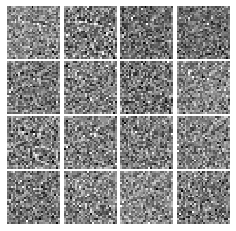


Iter: 250


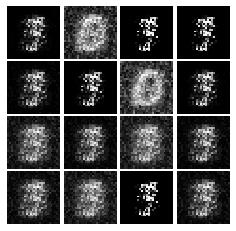


Iter: 500


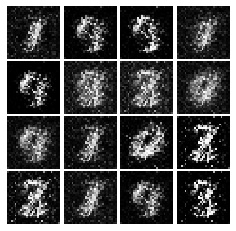


Iter: 750


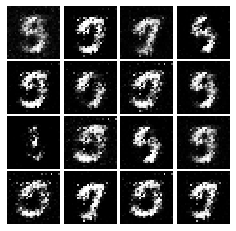


Iter: 1000


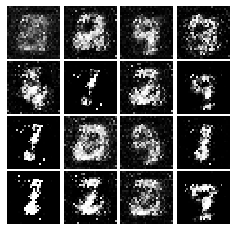


Iter: 1250


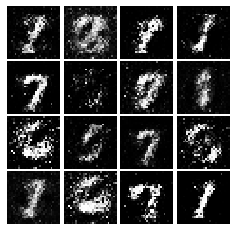


Iter: 1500


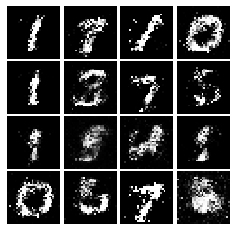


Iter: 1750


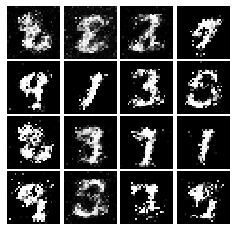


Iter: 2000


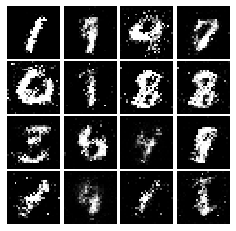


Iter: 2250


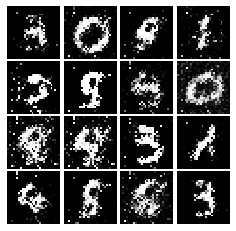


Iter: 2500


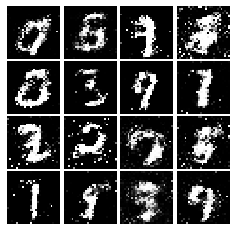


Iter: 2750


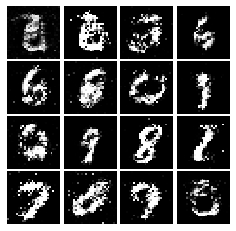


Iter: 3000


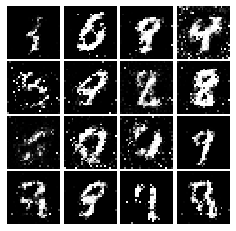


Iter: 3250


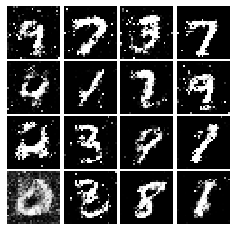


Iter: 3500


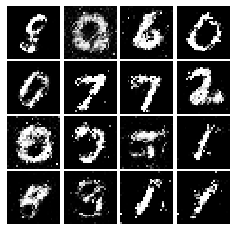


Iter: 3750


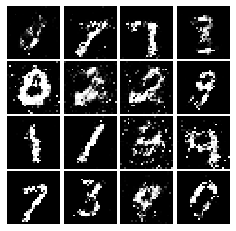

In [20]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

Vanilla GAN Fianl image:


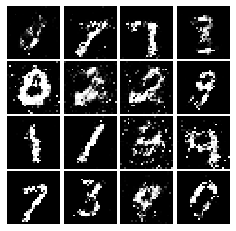

In [21]:
print("Vanilla GAN Fianl image:")
show_images(images[-1])
plt.show()

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Implement `build_dc_classifier` in `cs231n/gan_pytorch.py`

In [12]:
from cs231n.gan_pytorch import build_dc_classifier

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [13]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

Implement `build_dc_generator` in `cs231n/gan_pytorch.py`

In [18]:
from cs231n.gan_pytorch import build_dc_generator

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [19]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


In [29]:
D_DC = build_dc_classifier(batch_size).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train, num_epochs=5)

Iter: 0, D: 1.426, G:0.6286
Iter: 250, D: 1.214, G:0.8418
Iter: 500, D: 1.223, G:0.981
Iter: 750, D: 1.186, G:1.61
Iter: 1000, D: 1.203, G:0.9502
Iter: 1250, D: 1.221, G:0.9377
Iter: 1500, D: 1.114, G:0.8769
Iter: 1750, D: 1.102, G:0.8272


Run the cell below to show generated images.

Iter: 0


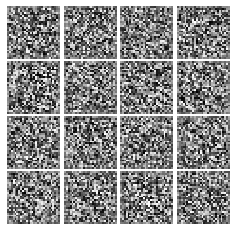


Iter: 250


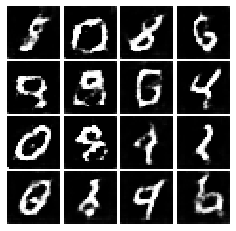


Iter: 500


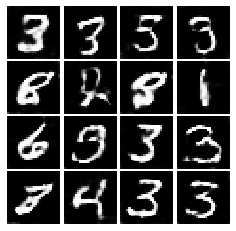


Iter: 750


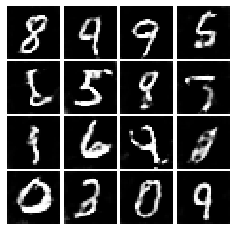


Iter: 1000


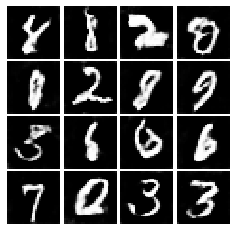


Iter: 1250


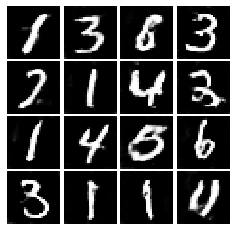


Iter: 1500


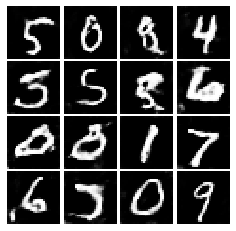


Iter: 1750


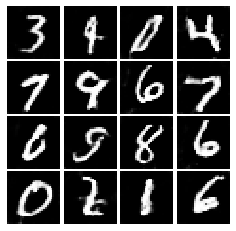

In [30]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

DCGAN Fianl image:


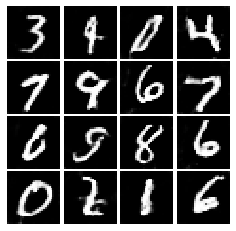

In [31]:
print("DCGAN Fianl image:")
show_images(images[-1])
plt.show()